In [1]:
import psycopg2

import pandas as pd

import seaborn as sns

import plotly.express as px
from plotly import graph_objects as go

sns.set_theme(style="whitegrid")

In [2]:
conn = psycopg2.connect(
    host="158.160.52.106",
    port=5432,
    database="postgres",
    user="student",
    password="JvLda93aA",
)
cur = conn.cursor()

In [3]:
query_month = '''select
	date(date_trunc('month', c.visit_dttm)) as month,
	count(distinct c.client_rk) as client,
	count(distinct a.account_rk) as account,
	count(distinct a2.account_rk) as application,
	count(distinct a2.account_rk) filter(
	where g.game_flg = 1) as game_flg
from
	msu_analytics.client c
left join msu_analytics.account a
	on c.client_rk = a.client_rk
left join msu_analytics.application a2
	on a.account_rk = a2.account_rk
left join msu_analytics.game g
	on a2.game_rk = g.game_rk 
group by
	1
order by
	1;
'''

cur.execute(query_month)
month_df = pd.DataFrame(cur.fetchall()).rename(columns={0: 'month', 
                                                        1: 'visited',
                                                        2: 'registered',
                                                        3: 'applied',
                                                        4: 'played'})

month_df.set_index('month', inplace=True)
month_df

,visited,registered,applied,played
month,,,,
2022-09-01,778,190,51,39
2022-10-01,843,217,65,56
2022-11-01,786,200,56,50
2022-12-01,805,196,57,33
2023-01-01,852,213,64,20
2023-02-01,32,8,0,0


In [4]:
steps = ['Зашло на сайт', 'Зарегистрировалось', 'Отправило заявку на игру', 'Пришло на игру']

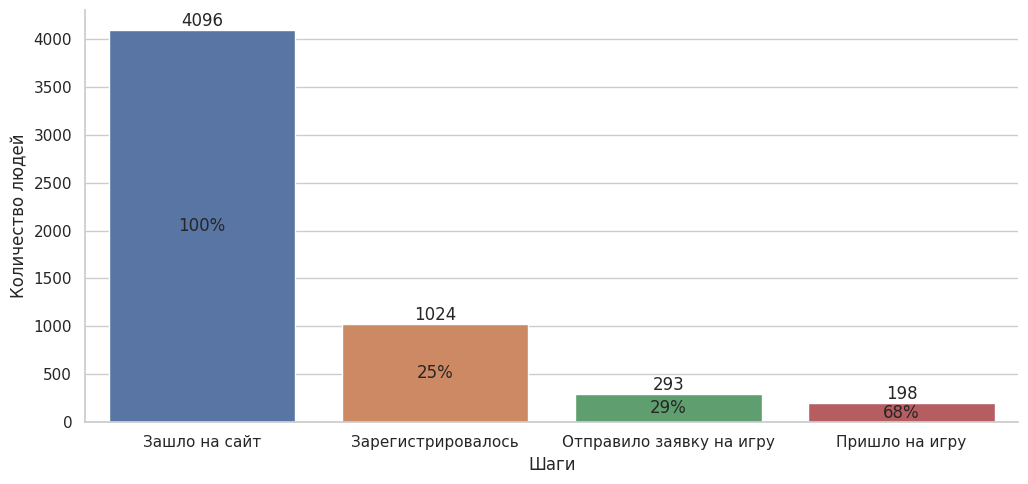

In [5]:
g = sns.catplot(month_df.agg('sum').reset_index(), 
                x='index', 
                y=0, 
                kind="bar")
g.set_xticklabels(steps)
g.fig.set_figwidth(12)
g.set_axis_labels("Шаги", "Количество людей")
ax = g.facet_axis(0,0)

for c in ax.containers:
    labels = [f'{v.get_height():.0f}' for v in c]
    labels_num = ['100%']
    for i in range(1, 4):
      labels_num.append(f'{c[i].get_height() / c[i - 1].get_height() * 100:.0f}%')
    ax.bar_label(c, labels=labels, label_type='edge')
    ax.bar_label(c, labels=labels_num, label_type='center')

In [6]:
query_week = '''select
	date(date_trunc('week', c.visit_dttm)) as week,
	count(distinct c.client_rk) as client,
	count(distinct a.account_rk) as account,
	count(distinct a2.account_rk) as application,
	count(distinct a2.account_rk) filter(
	where g.game_flg = 1) as game_flg
from
	msu_analytics.client c
left join msu_analytics.account a
	on c.client_rk = a.client_rk
left join msu_analytics.application a2
	on a.account_rk = a2.account_rk
left join msu_analytics.game g
	on a2.game_rk = g.game_rk 
group by
	1
order by
	1;
'''

cur.execute(query_week)
week_df = pd.DataFrame(cur.fetchall()).rename(columns={0: 'week', 
                                                        1: 'visited',
                                                        2: 'registered',
                                                        3: 'applied',
                                                        4: 'played'})

week_df.set_index('week', inplace=True)
week_df.head()


,visited,registered,applied,played
week,,,,
2022-08-29,111,32,7,5
2022-09-05,184,31,6,5
2022-09-12,167,43,16,8
2022-09-19,181,45,12,11
2022-09-26,195,59,17,17


Конверсия считается от количества зашедших на сайт

In [7]:
week_df['registration_2_visit'] = (week_df['registered'].values / week_df['visited'].values) * 100
week_df['application_2_visit'] = (week_df['applied'].values / week_df['visited'].values) * 100
week_df['game_2_visit'] = (week_df['played'].values / week_df['visited'].values) * 100

week_df['registration_2_visit'] = week_df['registration_2_visit'].astype(int)
week_df['application_2_visit'] = week_df['application_2_visit'].astype(int)
week_df['game_2_visit'] = week_df['game_2_visit'].astype(int)

In [8]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Сентябрь',
    y = steps,
    x = month_df.iloc[0],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Октябрь',
    orientation = "h",
    y = steps,
    x = month_df.iloc[1],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Ноябрь',
    orientation = "h",
    y = steps,
    x = month_df.iloc[2],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Декабрь',
    orientation = "h",
    y = steps,
    x = month_df.iloc[3],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Январь',
    orientation = "h",
    y = steps,
    x = month_df.iloc[4],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(
    title="Воронка пользователей по месяцам",
    yaxis_title="Шаги",
    legend_title="Месяц",
    font=dict(
        size=14,
    )
)


fig.show()

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=week_df.index.values, 
                         y=week_df['visited'].values,
                         mode='lines+markers',
                         name='Зашло на сайт'))

fig.add_trace(go.Scatter(x=week_df.index.values, 
                         y=week_df['registered'].values,
                         text=week_df['registration_2_visit'],
                         textposition='top right',
                         textfont=dict(color='red'),
                         mode='lines+markers+text',
                         texttemplate='%{text}%',
                         name='Зарегистрировалось'))

fig.add_trace(go.Scatter(x=week_df.index.values, 
                         y=week_df['applied'].values,
                         text=week_df['application_2_visit'],
                         textposition='top right',
                         textfont=dict(color='green'),
                         mode='lines+markers+text',
                         texttemplate='%{text}%',
                         name='Оставило заявку на игру'))

fig.add_trace(go.Scatter(x=week_df.index.values, 
                         y=week_df['played'].values,
                         text=week_df['game_2_visit'],
                         textposition='bottom left',
                         textfont=dict(color='purple'),
                         mode='lines+markers+text',
                         texttemplate='%{text}%',
                         name='Пришло на игру'))

fig.update_layout(
    xaxis={'type': 'category'},
    title="Воронка пользователей по неделям",
    yaxis_title="Количество пользователей",
    legend_title="Шаги",
    font=dict(
        size=14,
    )
)

fig.show()

# Выводы

Самая большая потеря пользователей происходит перед регистрацией. Между зарегистрировавшимися на игру и пришедшими не очень большая разница.